In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re  
import nltk
nltk.download('stopwords') 
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity

from scipy.cluster.hierarchy import linkage, dendrogram

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_excel('Film_User_Reviews.xlsx')
data['Rating'] = data['Rating'].replace(r'\n','', regex=True).str.split('/').str[0].astype(int)
review = data['Review']

In [3]:
data

,Unnamed: 0,Film Title,Review User,Title,Review,Rating
0,0,Palm Springs,fadlanamin,Weird but Good Weird,I was expecting a conventional rom-com where t...,8
1,1,Palm Springs,kjproulx,It's Very Hard to Dislike a Movie like Palm S...,Films that revolve around characters repeating...,9
2,2,Palm Springs,cartsghammond,Pure fun,Palm Springs is just such a good time of a mov...,9
3,3,Palm Springs,cardsrock,Simply terrific,I'm impressed that people are still able to fi...,8
4,4,Palm Springs,Loptimus06,A New Take On Groundhog Day,"Palm Springs is ""One of those infinite time-lo...",8
...,...,...,...,...,...,...
120,20,Desperados,omood-00755,Great comedy film,It was a good comedy film. Was it a masterliec...,9
121,21,Desperados,Worldpeece1,Predictable and boring,The main character was just annoying. Found my...,2
122,22,Desperados,boriquachula16,Couldn't skip through fast enough.,The ONLY good thing about this film is Lamorne...,1
123,23,Desperados,Elizabethchivers,Very fun chick flick,I was surprised to see so many bad reviews. Th...,8


In [4]:
review

0      I was expecting a conventional rom-com where t...
1      Films that revolve around characters repeating...
2      Palm Springs is just such a good time of a mov...
3      I'm impressed that people are still able to fi...
4      Palm Springs is "One of those infinite time-lo...
                             ...                        
120    It was a good comedy film. Was it a masterliec...
121    The main character was just annoying. Found my...
122    The ONLY good thing about this film is Lamorne...
123    I was surprised to see so many bad reviews. Th...
124    Decent movie but was disappointed in the story...
Name: Review, Length: 125, dtype: object

In [5]:
# Initialize empty array 
# to append clean text  
corpus = []  
  
# 1000 (reviews) rows to clean 
for i in range(0, 125):  
      
    # column : "Review", row ith 
    review = re.sub('[^a-zA-Z]', ' ', data['Review'][i])  
      
    # convert all cases to lower cases 
    review = review.lower()  
      
    # split to array(default delimiter is " ") 
    review = review.split()  
      
    # creating PorterStemmer object to 
    # take main stem of each word 
    ps = PorterStemmer()  
      
    # loop for stemming each word 
    # in string array at ith row     
    review = [ps.stem(word) for word in review 
                if not word in set(stopwords.words('english'))]  
                  
    # rejoin all string array elements 
    # to create back into a string 
    review = ' '.join(review)   
      
    # append each string to create 
    # array of clean text  
    corpus.append(review)  

In [6]:
len(corpus)

125

In [7]:
stemmer = SnowballStemmer("english")
def tokenize_and_stem(text):

    # Tokenize by sentence, then by word
    tokens = [y for x in nltk.sent_tokenize(text) for y in nltk.word_tokenize(x)]

    # Filter out raw tokens to remove noise
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]

    # Stem the filtered_tokens
    stems = [stemmer.stem(word) for word in filtered_tokens]

    return stems

In [8]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                   min_df=0.2, stop_words='english',
                                   use_idf=True, tokenizer=tokenize_and_stem,
                                   ngram_range=(1,3))

In [9]:
tfidf_matrix =  tfidf_vectorizer.fit_transform([x for x in data['Review']])

print(tfidf_matrix.shape)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(125, 16)


In [10]:
# Create a KMeans object with 3 clusters and save as km
km = KMeans(n_clusters=3, random_state = 10)

# Fit the k-means object with tfidf_matrix
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

# Create a column cluster to denote the generated cluster for each movie
data["cluster_3"] = clusters

# Display number of films per cluster (clusters from 0 to 4)
data['cluster_3'].value_counts()

1    49
0    42
2    34
Name: cluster_3, dtype: int64

In [11]:
# Create a KMeans object with 5 clusters and save as km
km = KMeans(n_clusters=5, random_state = 10)

# Fit the k-means object with tfidf_matrix
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

# Create a column cluster to denote the generated cluster for each movie
data["cluster_5"] = clusters

# Display number of films per cluster (clusters from 0 to 4)
data['cluster_5'].value_counts()

1    34
4    28
2    28
0    23
3    12
Name: cluster_5, dtype: int64

In [17]:
data

,Unnamed: 0,Film Title,Review User,Title,Review,Rating,cluster_3,cluster_5
0,0,Palm Springs,fadlanamin,Weird but Good Weird,I was expecting a conventional rom-com where t...,8,0,1
1,1,Palm Springs,kjproulx,It's Very Hard to Dislike a Movie like Palm S...,Films that revolve around characters repeating...,9,2,4
2,2,Palm Springs,cartsghammond,Pure fun,Palm Springs is just such a good time of a mov...,9,0,2
3,3,Palm Springs,cardsrock,Simply terrific,I'm impressed that people are still able to fi...,8,2,4
4,4,Palm Springs,Loptimus06,A New Take On Groundhog Day,"Palm Springs is ""One of those infinite time-lo...",8,1,2
...,...,...,...,...,...,...,...,...
120,20,Desperados,omood-00755,Great comedy film,It was a good comedy film. Was it a masterliec...,9,2,4
121,21,Desperados,Worldpeece1,Predictable and boring,The main character was just annoying. Found my...,2,0,2
122,22,Desperados,boriquachula16,Couldn't skip through fast enough.,The ONLY good thing about this film is Lamorne...,1,2,4
123,23,Desperados,Elizabethchivers,Very fun chick flick,I was surprised to see so many bad reviews. Th...,8,1,0


C:\Users\vivek\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 11088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\vivek\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 55356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\vivek\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 57253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\vivek\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 55357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\vivek\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 56397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\vivek\AppData\Roaming\Pyth

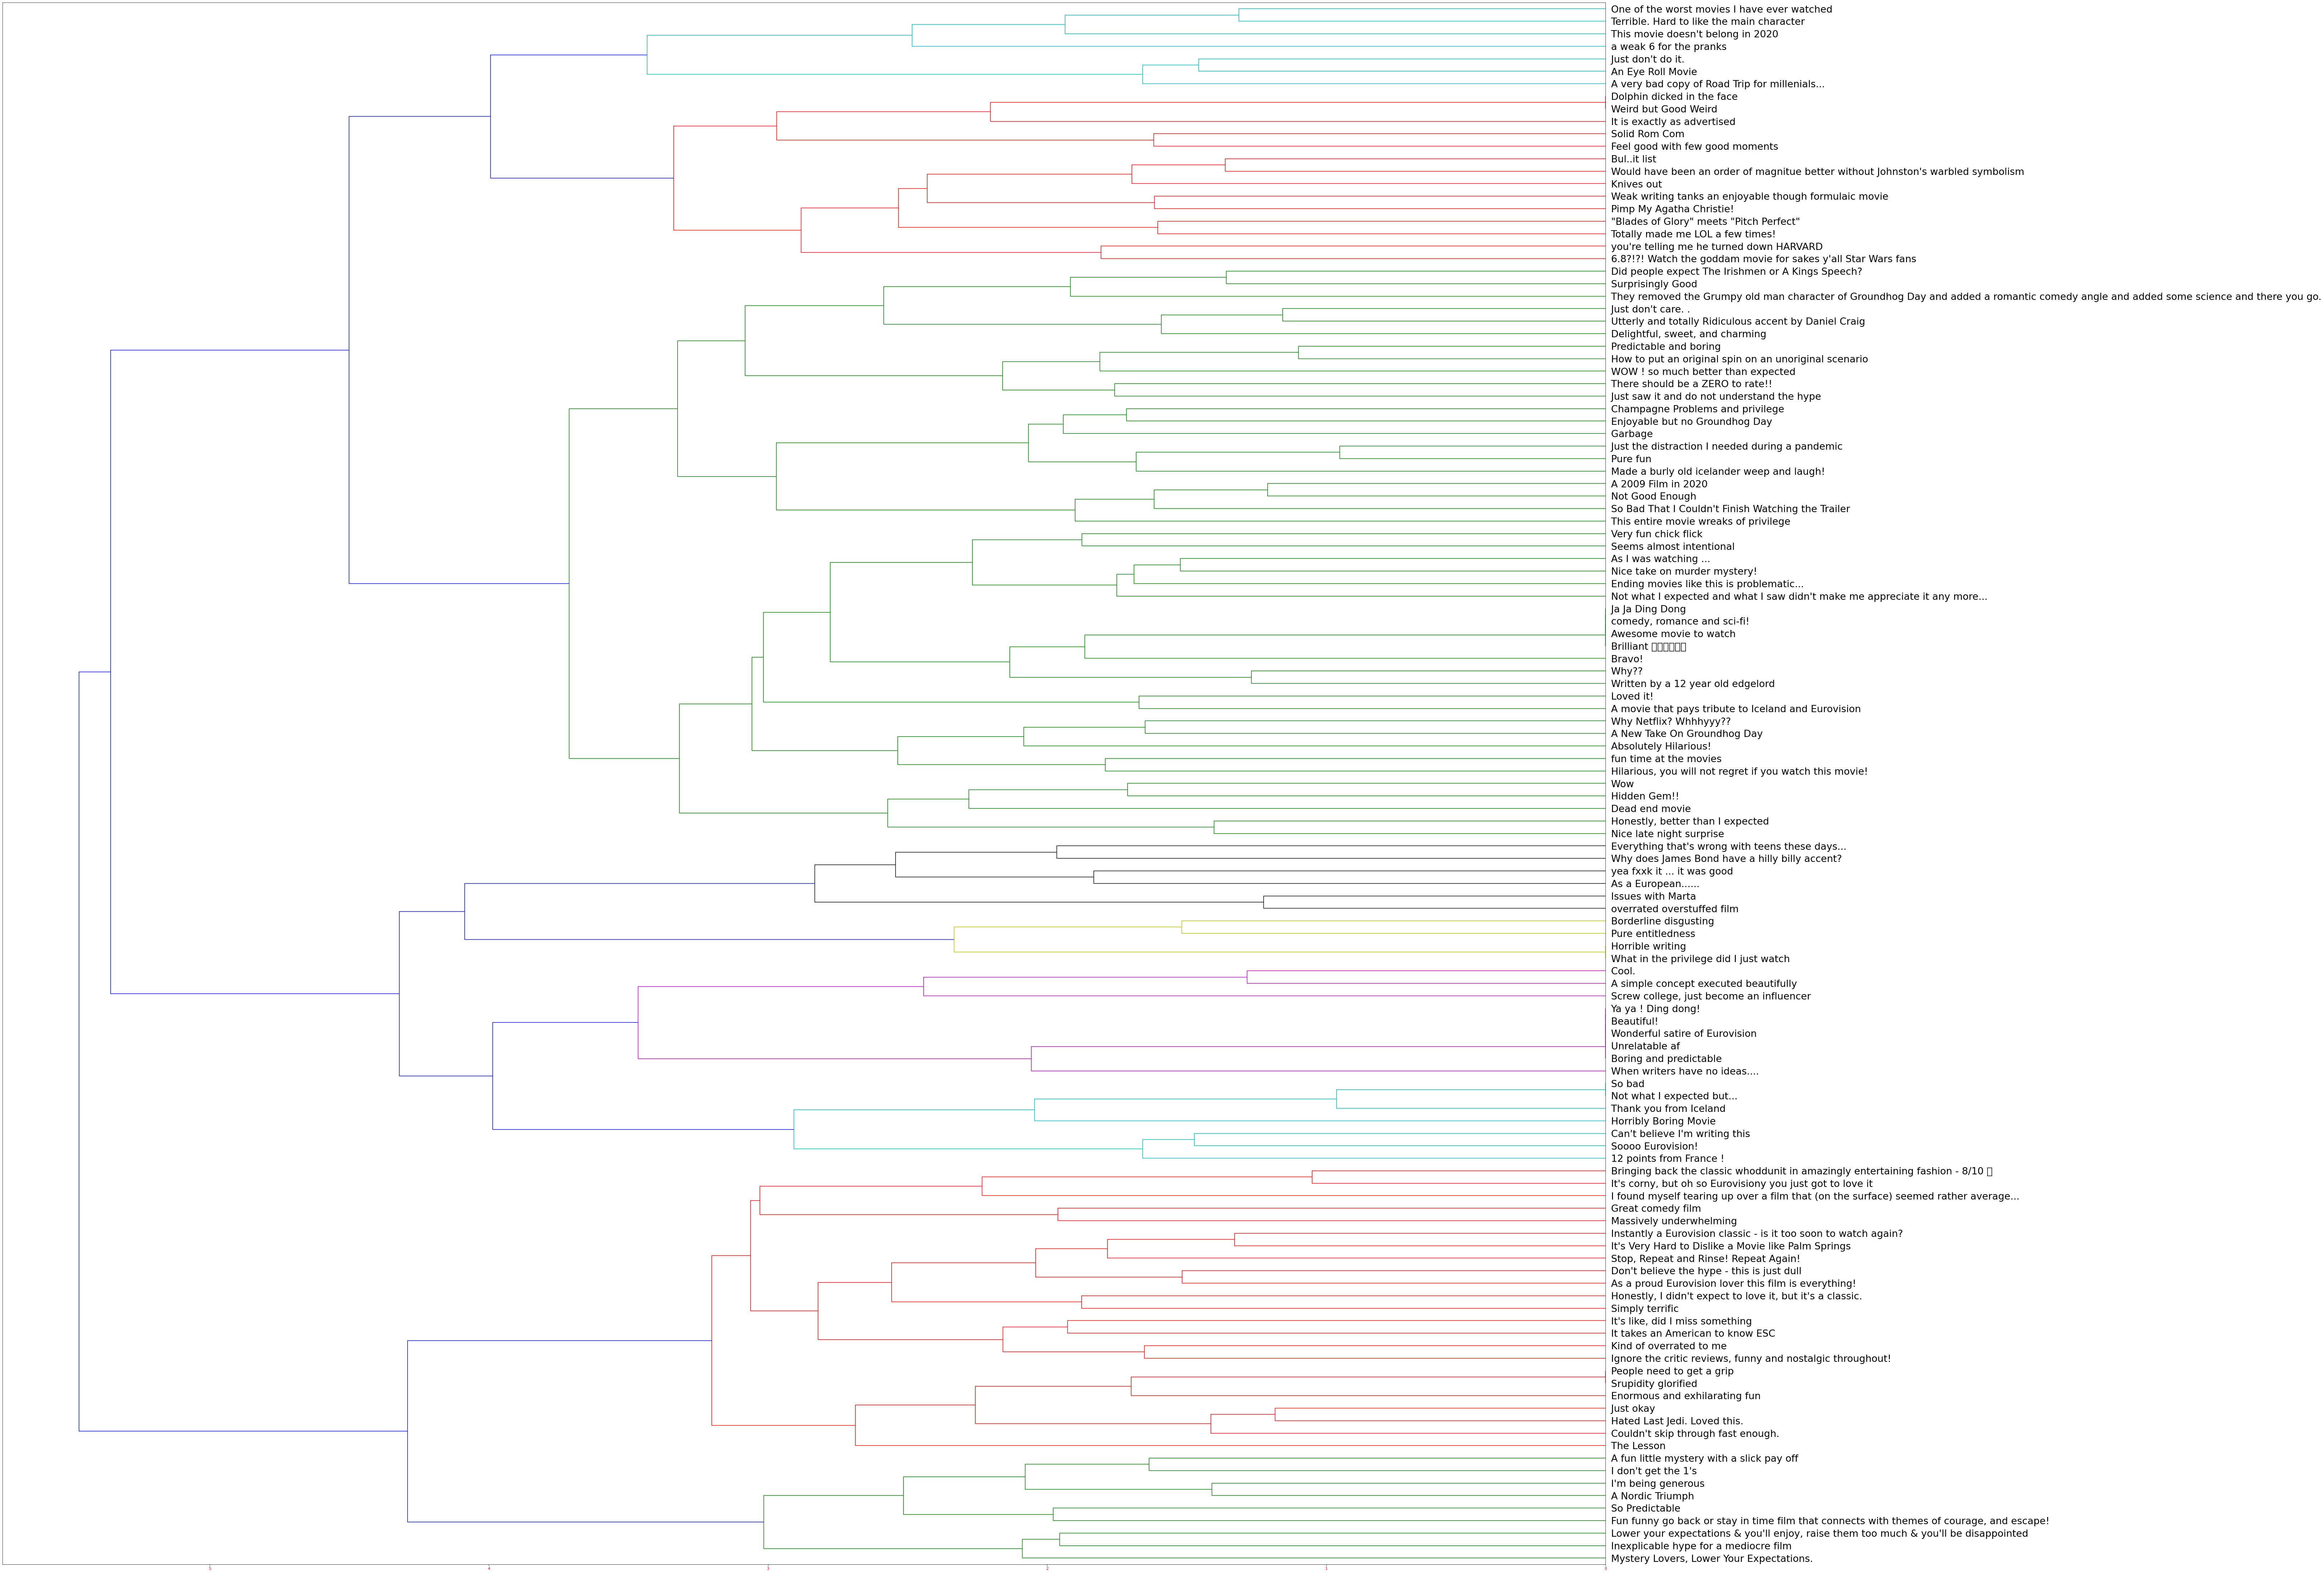

In [12]:
# Calculate the similarity distance
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

# Create mergings matrix
mergings = linkage(similarity_distance, method='complete')

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(mergings, orientation="left",
               labels=[x for x in data["Title"]],
               #leaf_rotation=90,
               leaf_font_size=27,
)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(80, 80)

# Show the plotted dendrogram
plt.show()